<a href="https://colab.research.google.com/github/VMBoehm/DeNoPa/blob/master/EL2O.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
# import tensorflow as tf
# tf.enable_eager_execution()

# x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

# with tf.GradientTape() as t:
#   with tf.GradientTape() as t2:
#     y = x * x * x
#   # Compute the gradient inside the 't' context manager
#   # which means the gradient computation is differentiable as well.
#   dy_dx = t2.gradient(y, x)
# d2y_dx2 = t.gradient(dy_dx, x)

# assert dy_dx.numpy() == 3.0
# assert d2y_dx2.numpy() == 6.0
# print( d2y_dx2.numpy())

Instructions for updating:
Colocations handled automatically by placer.
6.0


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.python.ops.parallel_for.gradients import jacobian
tfd = tfp.distributions
tfb = tfp.bijectors
# IMAGE_SHAPE = [28, 28, 1]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
import gzip, zipfile, tarfile
import os, shutil, re, string, urllib, fnmatch
import pickle as pkl

def _download_mnist_realval(dataset):
    """
    Download the MNIST dataset if it is not present.
    :return: The train, test and validation set.
    """
    origin = (
        'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
    )
    print('Downloading data from %s' % origin)
    urllib.request.urlretrieve(origin, dataset)

def _get_datafolder_path():
    full_path = os.path.abspath('.')
    path = full_path +'/data'
    return path

def load_mnist_realval(
        dataset=_get_datafolder_path()+'/mnist_real/mnist.pkl.gz'):
    '''
    Loads the real valued MNIST dataset
    :param dataset: path to dataset file
    :return: None
    '''
    if not os.path.isfile(dataset):
        datasetfolder = os.path.dirname(dataset)
        if not os.path.exists(datasetfolder):
            os.makedirs(datasetfolder)
        _download_mnist_realval(dataset)

    f = gzip.open(dataset, 'rb')
    train_set, valid_set, test_set = pkl.load(f, encoding='latin1')
    f.close()
    x_train, targets_train = train_set[0], train_set[1]
    x_valid, targets_valid = valid_set[0], valid_set[1]
    x_test, targets_test = test_set[0], test_set[1]
    return x_train, targets_train, x_valid, targets_valid, x_test, targets_test

In [4]:
x_train, targets_train, x_valid, targets_valid, x_test, targets_test = load_mnist_realval()

In [0]:
tf.reset_default_graph()
#tf.enable_eager_execution()

# x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0
# y = x * x * x
#   # Compute the gradient inside the 't' context manager
#   # which means the gradient computation is differentiable as well.
# dy_dx = tf.gradients(y, x)
# dy_dx2= tf.gradients(dy_dx,x)

batch_size  = 2#256
hidden_size = 4

# def inference(in_net):
#     with tf.variable_scope('generator/inference', reuse=tf.AUTO_REUSE):
#         net = tf.layers.dense(in_net, 512, name='dense_1', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 256, name='dense_3', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 2*hidden_size, name='dense_5', activation=None)
#     return net

# def generator(in_net):
#     with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
#         net = tf.layers.dense(in_net, 256, name='dense_1', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 384, name='dense_2', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 512, name='dense_3', activation=tf.nn.leaky_relu)
#         net = tf.layers.dense(net, 784, name='dense_5', activation=None)
#     return net

# lr    = tf.placeholder_with_default(0.001,shape=[])

# x     = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32)

# prior = tfd.MultivariateNormalDiag(tf.zeros(hidden_size), scale_identity_multiplier=1.0)

# mu, sigma        = tf.split(inference(x), 2, axis=-1)
# sigma            = tf.nn.softplus(sigma) + 0.0001
# approx_posterior = tfd.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

# z = approx_posterior.sample()

sample_size = tf.placeholder_with_default(500,shape=[])

# z_samples   = approx_posterior.sample(sample_size)

# x_samples   = tfd.Independent(tfd.Bernoulli(logits=generator(z_samples))).sample(sample_size)

# x_sims      = tfd.Independent(tfd.Bernoulli(logits=generator( prior.sample(batch_size)))).sample(sample_size)

# data_likelihood = tfd.Independent(tfd.Bernoulli(logits=generator(z)))

# kl_divergence   = tfd.kl_divergence(approx_posterior, prior)


# elbo            = - tf.reduce_mean(data_likelihood.log_prob(x) - kl_divergence,axis=0)

# # for now let's just see if we can recover the posterior with EL2O


# with tf.GradientTape(watch_accessed_variables=False) as t:

#ini_val= np.random.randn((batch_size*(hidden_size *(hidden_size +1) // 2))).reshape((batch_size,(hidden_size *(hidden_size +1)) // 2))

ini_val =np.ones((batch_size,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)#np.array(ini_val,dtype=np.float32)
mu_t = tf.constant(np.zeros((batch_size,hidden_size), dtype=np.float32))
                   
sigma_t = tf.constant(ini_val)

sigma_t2 = tfd.matrix_diag_transform(tfd.fill_triangular(sigma_t), transform=tf.nn.softplus)


approx_posterior2 = tfd.MultivariateNormalTriL(loc=mu_t,scale_tril=sigma_t2, name='posterior2')

z2                = approx_posterior2.sample()

big_sample        = approx_posterior2.sample(sample_size)

xx                = tf.Variable(z2)

p_of_z            = -approx_posterior2.log_prob(xx)

dpdz              = tf.gradients(p_of_z, xx) 

dpdz              = tf.gather(dpdz, 0)

hess              = tf.hessians(p_of_z,xx)

hess              = tf.gather(hess, 0)

hess2             = tf.reduce_sum( hess, axis = 2 )

eigen             = tf.linalg.eigh(hess2)

sigma_new         = tf.linalg.inv(hess2)
#sigma_new         = (sigma_new+tf.linalg.transpose(sigma_new))/2.

eigen2            = tf.linalg.eigh(sigma_new)

mu_new            = -tf.einsum('ijk,ik->ij', sigma_new,dpdz)+xx

sigma_ch          = tf.linalg.cholesky(sigma_new)

approx_posterior3 = tfd.MultivariateNormalFullCovariance(loc=mu_new, covariance_matrix=sigma_new)


z3                = approx_posterior3.sample(sample_size)

In [220]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
#covariances agree
res, res2= sess.run([sigma_t2, sigma_ch])
print(res,res2)
res, res2= sess.run([big_sample,z3])
mu, mu_n= sess.run([mu_t,mu_new])
print(mu,mu_n)

[[[1.3132616 0.        0.        0.       ]
  [1.        1.3132616 0.        0.       ]
  [1.        1.        1.3132616 0.       ]
  [1.        1.        1.        1.3132616]]

 [[1.3132616 0.        0.        0.       ]
  [1.        1.3132616 0.        0.       ]
  [1.        1.        1.3132616 0.       ]
  [1.        1.        1.        1.3132616]]] [[[1.3132615  0.         0.         0.        ]
  [1.         1.3132614  0.         0.        ]
  [0.9999999  0.99999964 1.3132616  0.        ]
  [0.9999999  0.99999964 0.9999999  1.3132617 ]]

 [[1.3132615  0.         0.         0.        ]
  [1.         1.3132614  0.         0.        ]
  [0.9999999  0.99999964 1.3132616  0.        ]
  [0.9999999  0.99999964 0.9999999  1.3132617 ]]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]] [[-4.7683716e-07  5.9604645e-07  1.1920929e-07  2.3841858e-07]
 [-2.3841858e-07 -3.5762787e-07 -4.1723251e-07 -4.7683716e-07]]


(array([ 3.,  1.,  1.,  4.,  5., 14., 33., 29., 49., 47., 48., 70., 59.,
        36., 34., 34., 18.,  5.,  6.,  4.]),
 array([-5.11126947, -4.70648193, -4.30169439, -3.89690685, -3.49211931,
        -3.08733177, -2.68254423, -2.27775669, -1.87296915, -1.46818161,
        -1.06339407, -0.65860653, -0.25381899,  0.15096855,  0.55575609,
         0.96054363,  1.36533117,  1.77011871,  2.17490625,  2.57969379,
         2.98448133]),
 <a list of 20 Patch objects>)

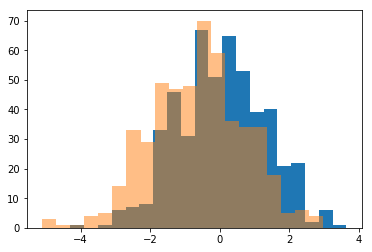

In [203]:
plt.hist(res.flatten(),bins=20)
plt.hist(res2.flatten(),alpha=0.5,bins=20)

In [0]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=5,zoom_range=0.1)
#datagen.fit(x_train.reshape((50000,28,28,1))) only needed if data trafos depend on the data itself

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
opt_op = optimizer.minimize(elbo)


In [39]:
#, feed_dict={x: x_train[:256,:].reshape([-1,784])})

TypeError: ignored

In [0]:
losses_data = []

In [14]:
imgsv_full= x_valid.reshape((-1,28,28,1))
print(imgsv_full.shape)

(10000, 28, 28, 1)


In [15]:
nepochs     = 20
jj          = 0.
lrate_start = 1e-3
maxcount    = 10
ii          = 0

for ep in range(nepochs):
    gen  = datagen.flow(x_train.reshape((50000,28,28,1)), batch_size=batch_size)
    
    count = 0
    print('new epoch')
    lrate=lrate_start
    for i in range(50000 // batch_size):
        # Train the inference model
        imgs  = next(gen)

        imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]

        if (len(imgsv) < batch_size) or ((ii+1)*batch_size==len(imgsv_full)):
          ii=0
          imgsv = imgsv_full[ii*batch_size:(ii+1)*batch_size]
        ii+=1
       
        
        if len(imgs) < batch_size:
            imgs = next(gen)

            
        imgs = )
        imgsv= imgsv.reshape([-1,784])

        # Train the generative model
        _, l  = sess.run([opt_op, elbo], feed_dict={x: imgs, lr:lrate})
        lv    = sess.run([elbo], feed_dict={x: imgsv})[0]
        
        if lv>l:
          jj+=1
        if l>lv:
          jj=0.
        
      
        losses_data.append(l)
        
        count += 1
        if count % 10 ==0:
            print(ep, l, lv, jj)
            
        if jj>maxcount:
            print('break criterion met')
            break
    if jj>(maxcount+5):
      break

new epoch
0 247.96353 224.15671 0.0
0 216.2948 212.33798 0.0
0 213.10228 205.99918 0.0
0 202.02841 189.48062 0.0
0 207.95206 189.24454 0.0
0 201.6712 187.60657 0.0
0 201.04956 185.86884 0.0
0 195.10867 187.5556 0.0
0 190.52542 182.0351 0.0
0 188.64752 176.09314 0.0
0 176.33641 170.47418 0.0
0 167.31085 168.70969 1.0
0 170.2677 156.43686 0.0
0 171.27542 158.157 0.0
0 162.39108 159.93669 0.0
0 157.57469 144.13014 0.0
0 159.75462 149.8852 0.0
0 160.4909 146.58557 0.0
0 152.04787 139.91037 0.0
new epoch
1 155.82843 139.76924 0.0
1 155.82921 145.23993 0.0
1 152.94733 142.80171 0.0
1 151.73895 135.73773 0.0
1 152.09831 135.49727 0.0
1 148.04993 132.07384 0.0
1 149.44104 136.3179 0.0
1 149.28453 141.63585 0.0
1 148.16125 139.11082 0.0
1 150.264 135.99951 0.0
1 146.4975 134.94283 0.0
1 145.87958 136.37921 0.0
1 136.7768 131.94855 0.0
1 143.25504 132.79483 0.0
1 144.80461 138.24612 0.0
1 141.09 124.26077 0.0
1 141.57858 129.79565 0.0
1 144.52571 127.86281 0.0
1 146.76819 121.680984 0.0
new epoc

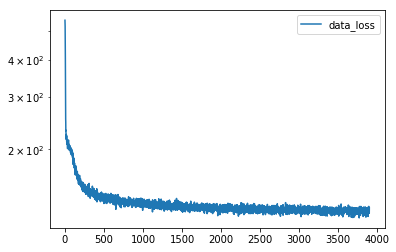

In [0]:
plot(losses_data,label='data_loss')
legend()
yscale('log')

In [0]:
res    = sess.run(z, feed_dict={x: x_test[0:batch_size]})
labels = targets_test[0:batch_size]

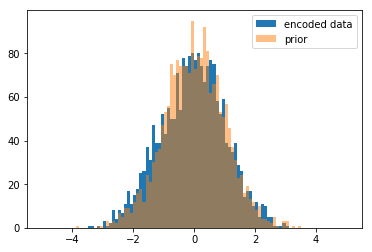

In [0]:
hist(res.flatten(),100,range=[-5,5],label='encoded data');
hist(randn(len(res.flatten())),100,range=[-5,5],alpha=0.5,label='prior');
legend()

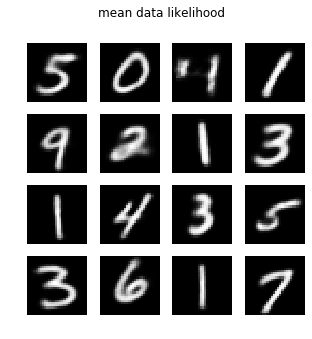

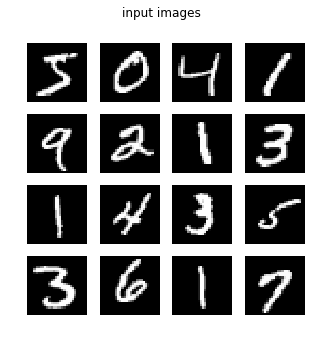

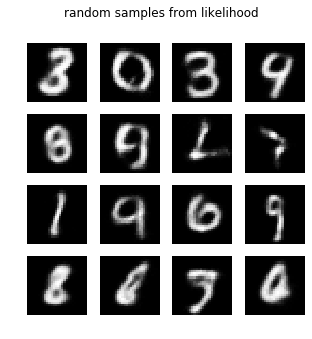

In [0]:
res, inim, s = sess.run([data_likelihood.mean(), x, x_sims], feed_dict={x: x_train[0:batch_size], sample_size: 400})
figure(figsize=(5,5))
suptitle('mean data likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow((res )[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

figure(figsize=(5,5))
suptitle('random samples from likelihood')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(s[:,i,:].reshape((-1,28,28)),axis=0),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
#mask[0:12,0:12]=0
mask = mask.reshape((28*28))

mask = np.asarray([mask]*batch_size)
#print(mask.shape)
masked_data = x_valid[0:batch_size]*mask

mask = np.ones(IMAGE_SHAPE, dtype=int)
#mask[0:12,0:12]=0
mask = mask.reshape((28*28))

In [0]:
#_, ll = sess.run([opt_op2, elbo2], feed_dict={x: masked_data, lr:lrate})
print(sess.run([shape1a,shape2a,shape6], feed_dict={x: masked_data, lr:lrate, mymask:mask}))
sess.run([shape1,shape2,shape3,shape4,shape5], feed_dict={x: masked_data, lr:lrate, mymask:mask})

[array([256], dtype=int32), array([256], dtype=int32), array([256, 784], dtype=int32)]


[array([256], dtype=int32),
 array([256, 784], dtype=int32),
 array([256, 784], dtype=int32),
 array([256], dtype=int32),
 array([], dtype=int32)]

In [0]:
posterior2_loss=[]

In [0]:
lrate=1e-2
for ii in range(1000):
  _, ll = sess.run([opt_op2, elbo2], feed_dict={x: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    mus, sigmas = sess.run([mu_t, sigma_t], feed_dict={x: masked_data})
    print(mus[0:10])
  print(ll)

[[-0.03130218 -0.03130219  0.03130219  0.03130219  0.03130219 -0.03130216
  -0.03130221 -0.03130209]
 [-0.03130208 -0.03130183 -0.03130197 -0.03130218  0.03130212 -0.03130209
   0.03130222  0.03130215]
 [-0.0313022   0.03130157  0.03130221 -0.0313022   0.03130188  0.03130192
   0.03130218 -0.03130204]
 [-0.03130217  0.03130217  0.0313022  -0.03130204  0.03129252  0.03130192
   0.03130221 -0.03130202]
 [ 0.03130214  0.03130222  0.03130221  0.03130222  0.03130214 -0.03130192
   0.03130221 -0.03130213]
 [-0.03130205 -0.03130195 -0.03130218  0.03130204  0.03130127 -0.03130211
  -0.0313022   0.03130218]
 [ 0.03130221 -0.03130207 -0.03130222  0.03130221 -0.03130214 -0.03130212
   0.03130222  0.03130219]
 [-0.03130207 -0.0313021  -0.0313022  -0.03130187  0.0313016  -0.03130168
  -0.0313022   0.03130221]
 [-0.03130195  0.0313015  -0.03130215 -0.03130185 -0.03129665  0.03130199
   0.03130221  0.03130219]
 [-0.03130215 -0.03130216 -0.03130196 -0.0313022   0.03130209 -0.03130058
  -0.03130214 -0.

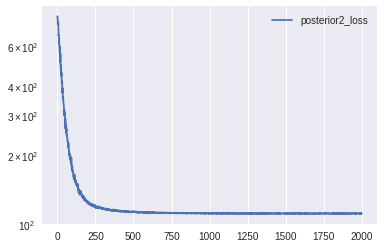

In [0]:
plot(posterior2_loss,label='posterior2_loss')
legend()
yscale('log')

In [0]:
res2 = sess.run(z2, feed_dict={x: masked_data[0:batch_size]})
res = sess.run(z, feed_dict={x: masked_data[0:batch_size]})

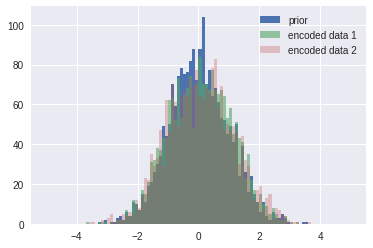

In [0]:
hist(randn(len(res.flatten())),100,range=[-5,5],label='prior');
hist(res.flatten(),100,range=[-5,5],alpha=0.6,label='encoded data 1');
hist(res2.flatten(),100,range=[-5,5],alpha=0.3,label='encoded data 2');
legend()

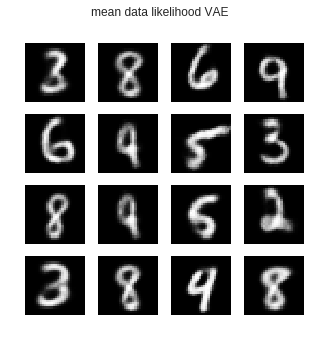

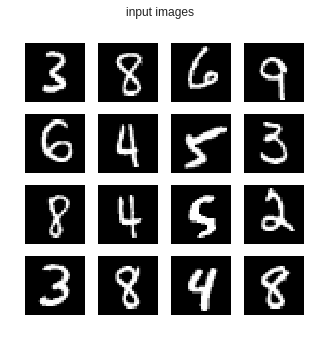

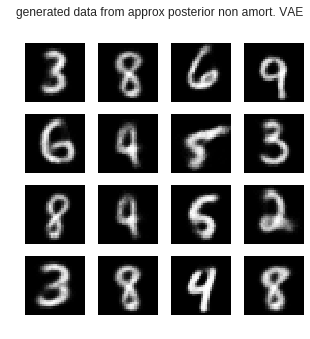

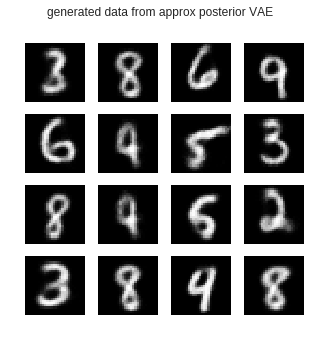

In [0]:
inim, xrecons2 = sess.run([x, x2_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 20})
xmean, xrecon          = sess.run([data_likelihood.mean(),x_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 20})


figure(figsize=(5,5))
suptitle('mean data likelihood VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow((xmean)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


# figure(figsize=(5,5))
# suptitle('mean data likelihood non amortized VAE')
# for i in range(16):
#     subplot(4,4,i+1)
#     imshow((res2)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
#     axis('off')


figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

    
figure(figsize=(5,5))
suptitle('generated data from approx posterior non amort. VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecons2[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('generated data from approx posterior VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecon[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

In [0]:
#has already been trained on one specific data set
data_from_mean_z = sess.run(likeli_zmean.mean(), feed_dict={x: masked_data[0:batch_size], mymask:mask, sample_size: 20})

(256, 784)


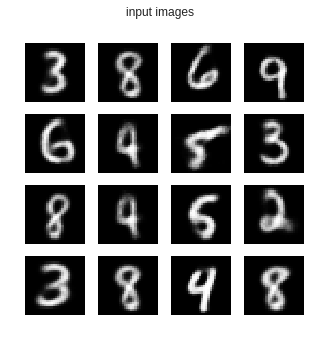

In [0]:
print(data_from_mean_z.shape)
figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(data_from_mean_z[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


In [0]:
mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[6:14,0:28]=0
mask = mask.reshape((28*28))

mask = np.asarray([mask]*batch_size)
print(mask.shape)
masked_data = x_valid[0:batch_size]*mask

mask = np.ones(IMAGE_SHAPE, dtype=int)
mask[6:14,0:28]=0
mask = mask.reshape((28*28))

(256, 784)


In [0]:
lrate=1e-2
for ii in range(1000):
  _, ll = sess.run([opt_op2, elbo2], feed_dict={x: masked_data, lr:lrate, mymask:mask})
  posterior2_loss.append(ll)
  if ii%100==0:
    mus, sigmas = sess.run([mu_t, sigma_t], feed_dict={x: masked_data, mymask:mask})
    print(mus[0:10])
  print(ll)

[[-1.0474024   0.52338845  0.5949422  -0.34823397  0.5560027   1.0913174
  -0.47332066 -0.12184178]
 [-1.2673969   1.3059385  -0.88418645 -1.3565693  -0.12668134  0.23944108
   0.2654715   1.2856654 ]
 [ 1.5307142   1.7314552   0.5560049  -0.98953193 -1.2634192  -0.99859273
  -0.20964059 -0.60273665]
 [ 0.51204306  1.1896449   1.4888327  -0.8165484   0.61181325 -1.9498332
   2.4481678   0.25689325]
 [-0.02351082  1.8942304  -0.80031323 -0.9329027   0.12791972 -1.2218987
  -0.80923146 -0.39245418]
 [ 0.6321306   2.216655    0.14751114  0.5765461   0.01892885  0.05221826
   1.3046118   0.5609653 ]
 [ 0.50912404 -1.7146658  -3.4065914   1.474641   -0.41283756  0.5224751
   0.4402983   0.37124455]
 [-1.5717046   0.9191852   0.6090809  -0.5776099   0.67667335  0.24884267
  -0.49994943 -1.5069828 ]
 [-0.5481648   0.57182324  0.26720044 -1.4361677  -1.1851199   0.73452044
   0.6059903   0.9618369 ]
 [ 0.61913735  1.8576065   0.46226206  0.44562146  0.24170059  0.10488611
   1.2348229   0.5465

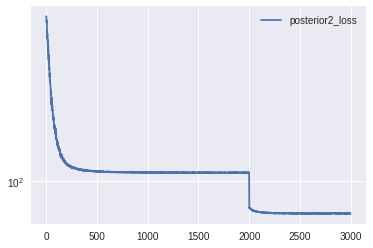

In [0]:
plot(posterior2_loss,label='posterior2_loss')
legend()
yscale('log')

In [0]:
res3 = sess.run(z2, feed_dict={x: masked_data[0:batch_size]})
#res = sess.run(z, feed_dict={x: masked_data[0:batch_size]})

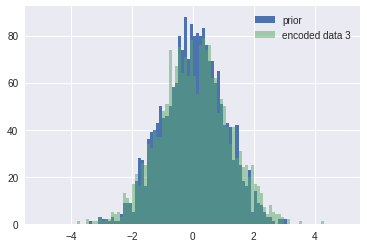

In [0]:
hist(randn(len(res3.flatten())),100,range=[-5,5],label='prior');
hist(res3.flatten(),100,range=[-5,5],alpha=0.5,label='encoded data 3');
legend()

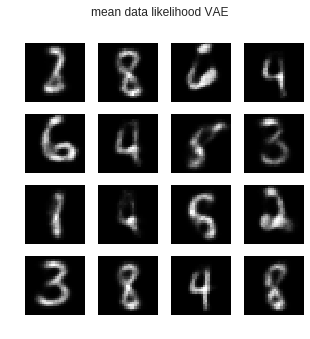

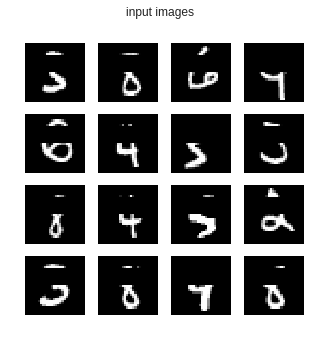

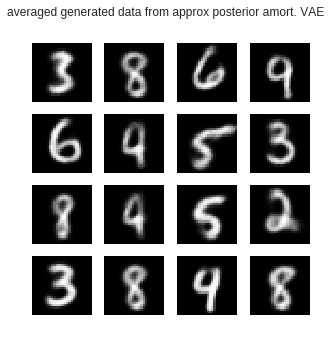

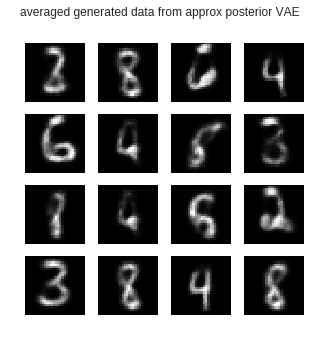

In [0]:
inim, xrecons2 = sess.run([x, x2_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 40})
xmean, xrecon          = sess.run([data_likelihood.mean(),x_samples], feed_dict={x: masked_data[0:batch_size], sample_size: 40})

figure(figsize=(5,5))
suptitle('mean data likelihood VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow((xmean)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')


# figure(figsize=(5,5))
# suptitle('mean data likelihood amortized VAE')
# for i in range(16):
#     subplot(4,4,i+1)
#     imshow((res2)[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
#     axis('off')


figure(figsize=(5,5))
suptitle('input images')
for i in range(16):
    subplot(4,4,i+1)
    imshow(inim[i].reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')

    
figure(figsize=(5,5))
suptitle('averaged generated data from approx posterior amort. VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecons2[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')
    
figure(figsize=(5,5))
suptitle('averaged generated data from approx posterior VAE')
for i in range(16):
    subplot(4,4,i+1)
    imshow(np.mean(xrecon[:,:,i,:],axis=(0,1)).reshape((28,28)),cmap='gray',vmin=0); #colorbar()
    axis('off')